# Test Trotterization on FakeJakarta with QREM and ZNE

- Status: OK

# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation import expectation_value

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_54085/3056705909.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Import Libraries

In [6]:
import sys
import importlib
sys.path.append("../../solutions/utils/")
import circuit_utils, zne_utils, tomography_utils, sgs_algorithm
importlib.reload(circuit_utils)
importlib.reload(zne_utils)
importlib.reload(tomography_utils)
importlib.reload(sgs_algorithm)
from circuit_utils import *
from zne_utils import *
from tomography_utils import *
from sgs_algorithm import *

# Set Parameters

In [7]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('2t/n')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Number of trotter steps
num_steps = 4
print("trotter step: ", num_steps)

scale_factors = [1.0, 2.0, 3.0]

trotter step:  4


# Prepare Circuits

logical circuits = little endian
name: lq = logical qubits 

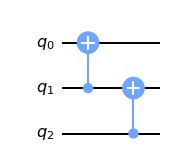

In [8]:
qc = QuantumCircuit(3)
subspace_decoder(qc, targets=[0, 1, 2])
qc.draw("mpl")

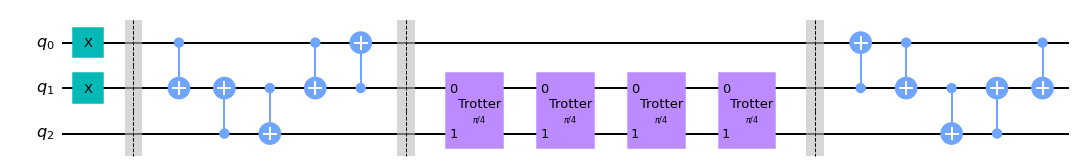

In [9]:
# Initialize quantum circuit for 3 qubits
# qr = QuantumRegister(num_qubits, name="q")

qc = QuantumCircuit(3)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
qc.barrier()
general_subspace_encoder(qc, targets=[0, 1, 2]) # encode
qc.barrier()
trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
qc.barrier()
general_subspace_decoder(qc, targets=[0, 1, 2]) # decode
qc = qc.bind_parameters({dt: target_time / num_steps})
qc.draw("mpl")

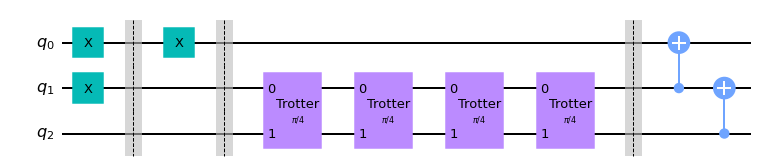

In [10]:
# Initialize quantum circuit for 3 qubits
# qr = QuantumRegister(num_qubits, name="q")

qc = QuantumCircuit(3)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
qc.barrier()
subspace_encoder_init110(qc, targets=[0, 1, 2]) # encode
qc.barrier()
trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
qc.barrier()
subspace_decoder(qc, targets=[0, 1, 2]) # decode
qc = qc.bind_parameters({dt: target_time / num_steps})
qc.draw("mpl")

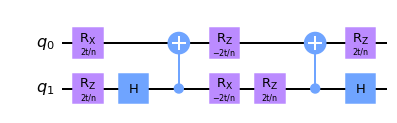

In [11]:
dt = Parameter('2t/n')
mdt = Parameter('-2t/n')
qc = QuantumCircuit(2)
qc.rx(dt, 0)
qc.rz(dt, 1)
qc.h(1)
qc.cx(1, 0)
qc.rz(mdt, 0)
qc.rx(mdt, 1)
qc.rz(dt, 1)
qc.cx(1, 0)
qc.h(1)
qc.rz(dt, 0)
qc.draw("mpl")

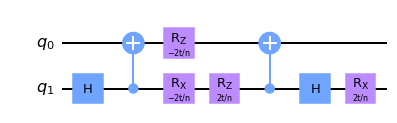

In [12]:
dt = Parameter('2t/n')
mdt = Parameter('-2t/n')
qc = QuantumCircuit(2)
qc.h(1)
qc.cx(1, 0)
qc.rz(mdt, 0)
qc.rx(mdt, 1)
qc.rz(dt, 1)
qc.cx(1, 0)
qc.h(1)
qc.rx(dt, 1)
qc.draw("mpl")